In [141]:
import tensorflow as tf

import numpy as np
import os
import time

In [142]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [143]:
!ls

alice_in_wonderland.txt  sample_data  training_checkpoints


In [144]:
from google.colab import files
files.upload()

{}

In [145]:
!ls

alice_in_wonderland.txt  sample_data  training_checkpoints


In [146]:
path_to_file = "alice_in_wonderland.txt"

In [147]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 148574 characters


In [148]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

72 unique characters


In [149]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [150]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

ids = ids_from_chars(chars)
ids

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [151]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [152]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(148574,), dtype=int64, numpy=array([17, 58, 55, ..., 21, 30, 20])>

In [153]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [154]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

A
l
i
c
e
'
s
 
A
d


In [155]:
seq_length = 100
examples_per_epoch = len(text)#(seq_length+1)
print(f'Examples per epoch:{examples_per_epoch}')

Examples per epoch:148574


In [157]:
num_elements = 0
for element in dataset:
  num_elements += 1
  #print(element)
print(f'Number of elements: {num_elements}')

Number of elements: 22


In [158]:
type(sequences)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [159]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'A' b'l' b'i' b'c' b'e' b"'" b's' b' ' b'A' b'd' b'v' b'e' b'n' b't'
 b'u' b'r' b'e' b's' b' ' b'i' b'n' b' ' b'W' b'o' b'n' b'd' b'e' b'r'
 b'l' b'a' b'n' b'd' b'\n' b'\n' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' '
 b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b'A' b'L' b'I' b'C' b'E' b"'"
 b'S' b' ' b'A' b'D' b'V' b'E' b'N' b'T' b'U' b'R' b'E' b'S' b' ' b'I'
 b'N' b' ' b'W' b'O' b'N' b'D' b'E' b'R' b'L' b'A' b'N' b'D' b'\n' b'\n'
 b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' '
 b' ' b' ' b' '], shape=(101,), dtype=string)


In [160]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b"Alice's Adventures in Wonderland\n\n                ALICE'S ADVENTURES IN WONDERLAND\n\n                 "
b'         Lewis Carroll\n\n               THE MILLENNIUM FULCRUM EDITION 3.0\n\n\n\n\n                       '
b'     CHAPTER I\n\n                      Down the Rabbit-Hole\n\n\n  Alice was beginning to get very tired '
b'of sitting by her sister\non the bank, and of having nothing to do:  once or twice she had\npeeped into'
b' the book her sister was reading, but it had no\npictures or conversations in it, `and what is the use'


In [161]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [162]:
split_input_target(list("Tensorflow"))
dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b"Alice's Adventures in Wonderland\n\n                ALICE'S ADVENTURES IN WONDERLAND\n\n                "
Target: b"lice's Adventures in Wonderland\n\n                ALICE'S ADVENTURES IN WONDERLAND\n\n                 "


In [163]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [164]:
df = tfds.as_dataframe(sequences)

In [165]:
train_size = int(df.shape[0] * 0.8)
test_size = df.shape[0] - train_size

In [166]:
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size).take(test_size)

In [167]:
test_ds

<TakeDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [168]:
import tensorflow_datasets as tfds

In [169]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [170]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [171]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [172]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 73) # (batch_size, sequence_length, vocab_size)


In [173]:
model.summary()

Model: "my_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  18688     
                                                                 
 gru_4 (GRU)                 multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  74825     
                                                                 
Total params: 4,031,817
Trainable params: 4,031,817
Non-trainable params: 0
_________________________________________________________________


In [174]:
model.compile(optimizer='adam', loss=loss)

In [175]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [176]:
EPOCHS = 30

In [177]:
history = model.fit(train_ds , validation_data=test_ds, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
22/22 [==============================] - 3s 46ms/step - loss: 4.1171
Epoch 2/30
22/22 [==============================] - 1s 46ms/step - loss: 3.0774
Epoch 3/30
22/22 [==============================] - 1s 46ms/step - loss: 2.7847
Epoch 4/30
22/22 [==============================] - 1s 46ms/step - loss: 2.5325
Epoch 5/30
22/22 [==============================] - 1s 46ms/step - loss: 2.3691
Epoch 6/30
22/22 [==============================] - 1s 53ms/step - loss: 2.2427
Epoch 7/30
22/22 [==============================] - 1s 45ms/step - loss: 2.1465
Epoch 8/30
22/22 [==============================] - 1s 46ms/step - loss: 2.0615
Epoch 9/30
22/22 [==============================] - 1s 46ms/step - loss: 1.9826
Epoch 10/30
22/22 [==============================] - 1s 50ms/step - loss: 1.9095
Epoch 11/30
22/22 [==============================] - 1s 45ms/step - loss: 1.8415
Epoch 12/30
22/22 [==============================] - 1s 46ms/step - loss: 1.7733
Epoch 13/30
22/22 [==================

In [178]:
test_ds.take(1)

<TakeDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [179]:
for text in test_ds.take(5):
  print(text_from_ids(text).numpy())

In [180]:
import matplotlib.pyplot as plt

In [181]:
print(history.history.keys())

dict_keys(['loss'])


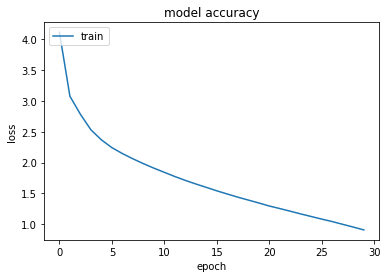

In [182]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [183]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [184]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [185]:
start = time.time()

def generate_text(seed_text):
  states = None
  next_char = tf.constant([seed_text])
  print(f'Initial next char: {next_char}')
  result = [next_char]

  for n in range(100):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

  result = tf.strings.join(result)
  end = time.time()
  print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
  print('\nRun time:', end - start)

In [186]:
generate_text('How are you?')

Initial next char: [b'How are you?']
How are you?' said the Gryphon.

  `question is, you might bird?'

  Just then all made of much!  I wonder's doe 

________________________________________________________________________________

Run time: 1.2355244159698486


In [187]:
generate_text('I am good?')

Initial next char: [b'I am good?']
I am good?
            Hexticl.
I question; but I'm never look down, ferriffing a puzzle.

  THAT did tlism in 

________________________________________________________________________________

Run time: 1.4768731594085693


In [188]:
generate_text('Have you read?')

Initial next char: [b'Have you read?']
Have you read?' the Hatter shoulders voice hand as it went voice she had been going over their places, `Shis first 

________________________________________________________________________________

Run time: 1.7225573062896729


In [189]:
generate_text('Have you read the?')

Initial next char: [b'Have you read the?']
Have you read the?' said Alice.

  `Off with here.'

  `NYIM!'  And you faintwnoigh?' the Allish now you dear thrued a 

________________________________________________________________________________

Run time: 1.9680051803588867


In [190]:
generate_text('Have you read the New?')

Initial next char: [b'Have you read the New?']
Have you read the New?
    Jus she'll he chowe
done of hear his way, `jus my yet-Dushed by the ear."


          Soup very 

________________________________________________________________________________

Run time: 2.218292474746704


In [191]:
generate_text('Have you read the New York?')

Initial next char: [b'Have you read the New York?']
Have you read the New York?'

  This dare will say,' said Alice.

  `Offectly the others injeed.'

  This saff she heard the Ma 

________________________________________________________________________________

Run time: 2.4703938961029053


In [192]:
generate_text('Have you read the New York Times?')

Initial next char: [b'Have you read the New York Times?']
Have you read the New York Times?' said the young her shopen
hester.  Now, Digah, and the snates, `How dyer that dreamad see,'s dawe  

________________________________________________________________________________

Run time: 2.7263870239257812
